# Graph Evolution

Graph evolution for given algorithms and dataset.

In [1]:
import os
import random
import time
import numpy as np
import networkx as nx

# local imports
from metrics import Recorder

# Seed for reproducibility
random.seed(42)

In [2]:
## CHANGE TO MATCH ALG AND DATASET
import node2vec as alg
from methods import Wagner2022 as Method

In [3]:
# Name of dataset being used
BASENAME, DIRECTED = "congress", True
# BASENAME, DIRECTED = "email_eu", True
# BASENAME, DIRECTED = "wiki_vote", True
# BASENAME, DIRECTED = "facebook", False
# BASENAME, DIRECTED = "lastfm", False
# BASENAME, DIRECTED = "deezer", False

# Graph Evolution
ITERATIONS = 30

# Metrics
VISIBILITY_RATIO = 0.1

In [4]:
# Constants for I/O
INPUT_DIR = "../input"
OUTPUT_DIR = "../data"

OUTPUT_PREFIX = f"{BASENAME}.{Method.__name__}.{alg.__name__}"

EDGELIST = BASENAME + ".txt"
MINORITIES = BASENAME + ".minorities"
EDGELIST_PATH = os.path.join(INPUT_DIR, EDGELIST)
MINORITIES_PATH = os.path.join(INPUT_DIR, MINORITIES)

In [5]:
init_g = nx.read_edgelist(EDGELIST_PATH, create_using=nx.DiGraph(), nodetype=int)

if not DIRECTED:
    # keep as DiGraph but add edges in opposite direction
    init_g.add_edges_from([(v, u) for (u, v) in init_g.edges()])

In [6]:
def degree_check(nx_g):
    """
    Check that all nodes have degree > 1.
    """
    for node in nx_g.nodes():
        if nx_g.out_degree(node) < 1:
            print(f"Node {node} has zero out degree")
        elif nx_g.in_degree(node) < 1:
            print(f"Node {node} has zero in degree")

## Network Evolution Following Wagner's Methods

In [7]:
def add_edges(nx_g, edges):
    """
    Adds edges to given graph.
    """
    nx_g.add_edges_from(edges)
    if not DIRECTED:
        nx_g.add_edges_from([(v, u) for (u, v) in edges])


def remove_edges(nx_g, edges):
    """
    Removes edges from given graph.
    """
    nx_g.remove_edges_from(edges)
    if not DIRECTED:
        nx_g.remove_edges_from([(v, u) for (u, v) in edges])

    
# IMPORTANT: we do deletions to keep a baseline for the clustering coefficient and 
# see the effect of the algorithm on the graphs structure
def evolve_network(nx_g, minorities):
    """
    Iteratively evolve the network by adding and removing edges.
    """
    # initialize algorithm
    nx_g = alg.initialize(nx_g, directed=DIRECTED, protected=minorities)

    # initialize method
    method = Method(nx_g, directed=DIRECTED, protected=minorities)

    # initialize recorder
    recorder = Recorder(directed=DIRECTED,
                        protected=minorities,
                        visibility_ratio=VISIBILITY_RATIO,
                        output_dir=OUTPUT_DIR,
                        output_prefix=OUTPUT_PREFIX)
    
    # initial metrics
    recorder.clear_files()
    recorder.record_metrics(nx_g)

    print("Iteration")
    print(f"0: {nx_g}")

    degree_check(nx_g)

    for i in range(1, ITERATIONS+1):

        to_predict = method.nodes_to_predict(nx_g)
        predictions = alg.predict(nx_g, directed=DIRECTED, nodes=to_predict)
        add_edges(nx_g, predictions)

        removals = method.edges_to_remove(nx_g)
        remove_edges(nx_g, removals)

        # compute metrics
        recorder.record_metrics(nx_g.copy())
  
        # if i % 2 == 0:
        print(f"{i}: {nx_g}")

        degree_check(nx_g)
    
    return recorder

In [8]:
minorities = []
with open(MINORITIES_PATH, "r") as f:
    for line in f:
        node = int(line.strip())
        minorities.append(node)

print(f"Minority size: {len(minorities)}")

Minority size: 71


In [9]:
# evolve the network
start = time.time()
recorder = evolve_network(init_g, minorities)
end = time.time()
print(f"Time elapsed: {end - start}")

Iteration
0: DiGraph with 475 nodes and 13289 edges
Node 31 has zero in degree
Node 227 has zero in degree
Node 240 has zero in degree
Node 356 has zero in degree
Node 434 has zero in degree
Node 456 has zero in degree
1: DiGraph with 475 nodes and 13289 edges
Node 456 has zero in degree
2: DiGraph with 475 nodes and 13289 edges
3: DiGraph with 475 nodes and 13289 edges
4: DiGraph with 475 nodes and 13289 edges
5: DiGraph with 475 nodes and 13289 edges
6: DiGraph with 475 nodes and 13289 edges
7: DiGraph with 475 nodes and 13289 edges
8: DiGraph with 475 nodes and 13289 edges
9: DiGraph with 475 nodes and 13289 edges
10: DiGraph with 475 nodes and 13289 edges
11: DiGraph with 475 nodes and 13289 edges
12: DiGraph with 475 nodes and 13289 edges
13: DiGraph with 475 nodes and 13289 edges
14: DiGraph with 475 nodes and 13289 edges
15: DiGraph with 475 nodes and 13289 edges
16: DiGraph with 475 nodes and 13289 edges
17: DiGraph with 475 nodes and 13289 edges
18: DiGraph with 475 nodes and 

## Summary

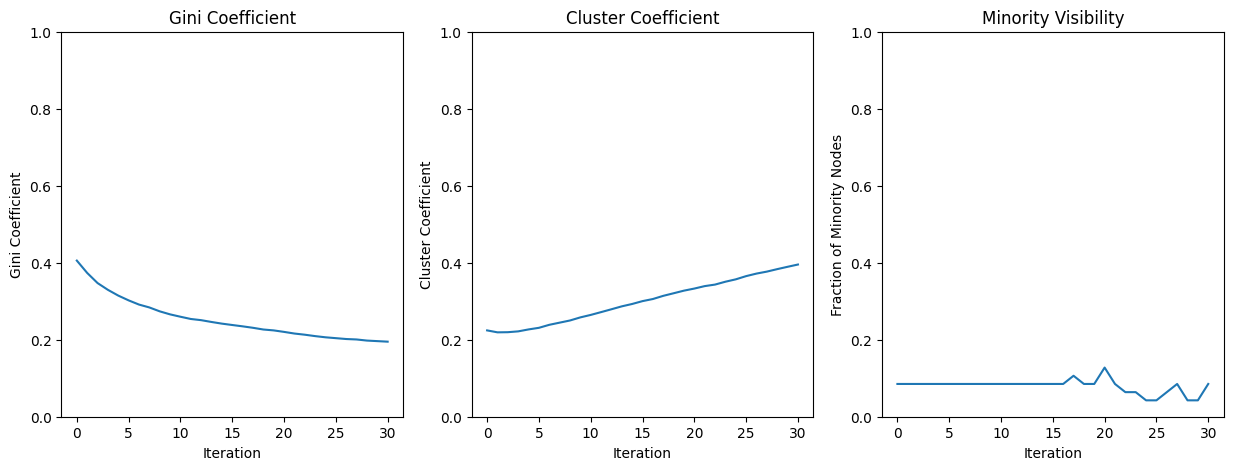

In [10]:
# plot data
recorder.plot_metrics()